In [1]:
import pandas as pd
import joblib

# Step 1: Load Data

In [5]:
from db_connect import get_connection

table_name = input("Enter the table name: ").strip()

# This portion of the project is using the player_table

engine = get_connection()
df = pd.read_sql(f"SELECT * FROM {table_name};", con = engine)

from player_dev_clean_df import clean_df
df_train, df_2024_transfers, df_2024_no_transfers, valid_players = clean_df(df)
best_stack_model = joblib.load('best_stack_model.pkl')

import eng_vars as ev
train_data_scaled = ev.split_scale(df_train)
scaler_x = train_data_scaled['scaler_x']

from p_dev_mdl_rslts import *
summary_2024_transfers = model_vs_actual(df_2024_transfers, scaler_x, best_stack_model)
summary_2024_no_transfers = model_vs_actual(df_2024_no_transfers, scaler_x, best_stack_model)

In [7]:
# Combine two 2024 dataframes so they are in one table in the database 
# Add transfer column to each DataFrame
def get_2024_team(summary_df, original_df):
    # Filter original_df for 2024 entries
    df_24 = original_df[original_df['year'] == 2024]
    
    # Select only player and team columns
    df_24_team = df_24[['player', 'team']].drop_duplicates()

    # Merge on player to get team
    merged_df = summary_df.merge(df_24_team, on = 'player', how = 'left')

    return merged_df

summary_2024_transfers['transfer'] = True
summary_2024_no_transfers['transfer'] = False

combined_df = pd.concat([summary_2024_transfers, summary_2024_no_transfers], ignore_index = True)

combined_df.sample(5)
team_combined_df = get_2024_team(combined_df, df)

team_combined_df.sample(5)

,player,Actual Composite Score (2024),Predicted,Estimated Difference,role,transfer,team
125,Luke Bumbalough,0.263856,0.408559,-0.144702,Role Player,True,Niagara
364,Osborn Shema,-0.433458,-0.171994,-0.261465,Limited Role,False,Iona
412,Nyzaiah Chambers,-0.992272,-0.696688,-0.295585,Limited Role,False,Norfolk St.
351,Brock Cunningham,0.604681,0.943939,-0.339257,Limited Role,False,Texas
127,Miguel Ayesa,-0.817980,-0.520316,-0.297664,Role Player,True,USC Upstate


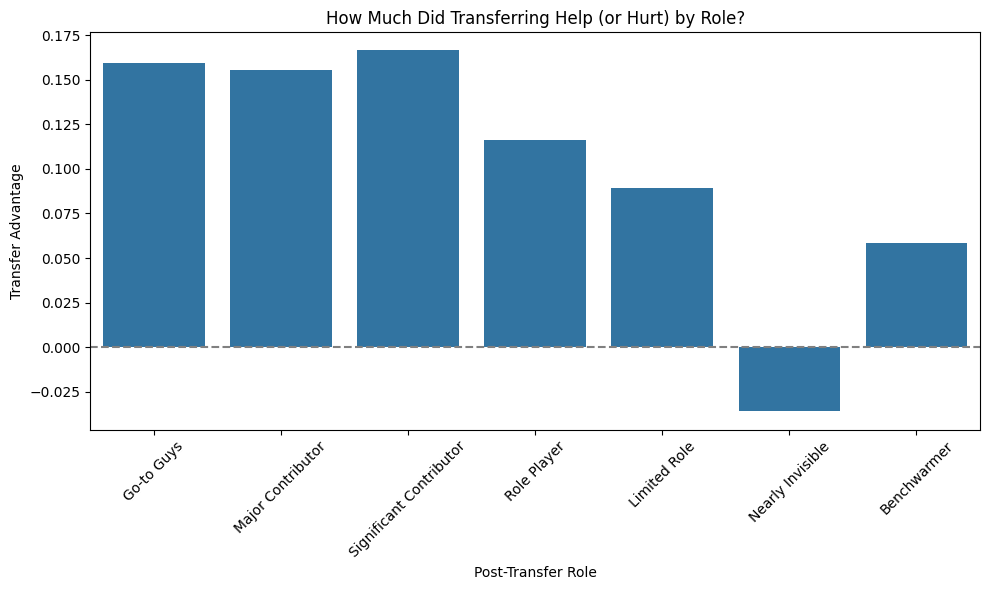

In [8]:
role_transfer_summary = combined_df.groupby(['role', 'transfer']).agg(
    avg_diff=('Estimated Difference', 'mean'),
    count=('player', 'count')
).reset_index().sort_values(['role', 'transfer'])

pivot_df = role_transfer_summary.pivot(index='role', columns='transfer', values='avg_diff')
pivot_df.columns = ['Non-Transfer', 'Transfer']
pivot_df['Transfer Advantage'] = pivot_df['Transfer'] - pivot_df['Non-Transfer']

# Plot
pivot_df = pivot_df.reset_index()
role_order = [
    'Go-to Guys','Major Contributor','Significant Contributor',
    'Role Player','Limited Role','Nearly Invisible','Benchwarmer'
]
plt.figure(figsize=(10, 6))
sns.barplot(data=pivot_df, x='role', y='Transfer Advantage', order=role_order)
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=45)
plt.ylabel('Transfer Advantage')
plt.xlabel('Post-Transfer Role')
plt.title('How Much Did Transferring Help (or Hurt) by Role?')
plt.tight_layout()
plt.show()

In [ ]:
# Compute outcome for players to show in df
def compute_outcome(df):
    df = df.copy()
    offense = df['o_rtg']
    defense = df['stl_pct'] + df['blk_pct'] + df['dr_pct']
    support = df['or_pct'] + df['a_rate']
    minutes = df['min_pct']

    norm_df = pd.DataFrame({
        'offense': offense,
        'defense': defense,
        'support': support,
        'minutes': minutes
    })

    scaler = StandardScaler()
    norm = scaler.fit_transform(norm_df)
    norm_df = pd.DataFrame(norm, columns=norm_df.columns)

    total = 1.0 + 0.7 + 0.3 + 0.5
    Y = (
        (1.0 / total) * norm_df['offense'] +
        (0.7 / total) * norm_df['defense'] +
        (0.3 / total) * norm_df['support'] +
        (0.5 / total) * norm_df['minutes']
    )
    
    df['model_score'] = Y
    return df

# apply
df_with_score = compute_outcome(df)
df_with_score = df_with_score.sort_values(['player', 'year'])
df_with_score['prior_score'] = df_with_score.groupby('player')['model_score'].shift(1)
df_with_score['score_jump'] = df_with_score['model_score'] - df_with_score['prior_score']


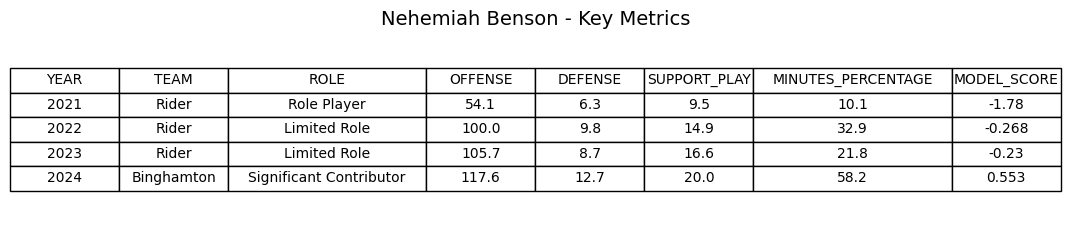

In [ ]:
# Filter for Nehemiah Benson
benson_df = df_with_score[(df_with_score['player'] == 'Nehemiah Benson') & (df_with_score['year'] != 2025)].sort_values(by='year').copy()

# Compute component metrics
benson_df['offense'] = benson_df['o_rtg']
benson_df['defense'] = benson_df['stl_pct'] + benson_df['blk_pct'] + benson_df['dr_pct']
benson_df['support_play'] = benson_df['or_pct'] + benson_df['a_rate']
benson_df['minutes_percentage'] = benson_df['min_pct']

# Select desired columns including model_score
benson_metrics = benson_df[[
    'year', 'team', 'role', 'offense', 'defense', 'support_play', 'minutes_percentage', 'model_score'
]].round(3)


benson_metrics.columns = [col.upper() for col in benson_metrics.columns]

fig, ax = plt.subplots(figsize=(11, len(benson_metrics) * 0.6))
ax.axis('off')
ax.set_frame_on(False)

table = ax.table(
    cellText=benson_metrics.values,
    colLabels=benson_metrics.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.1, 1.5)

# Widen columns
for key, cell in table.get_celld().items():
    if key[1] == 2:  
        cell.set_width(0.25) 
    elif key[1] == 6:
        cell.set_width(0.25) 

plt.title("Nehemiah Benson - Key Metrics", fontsize=14, pad=10)
plt.tight_layout()
plt.show()

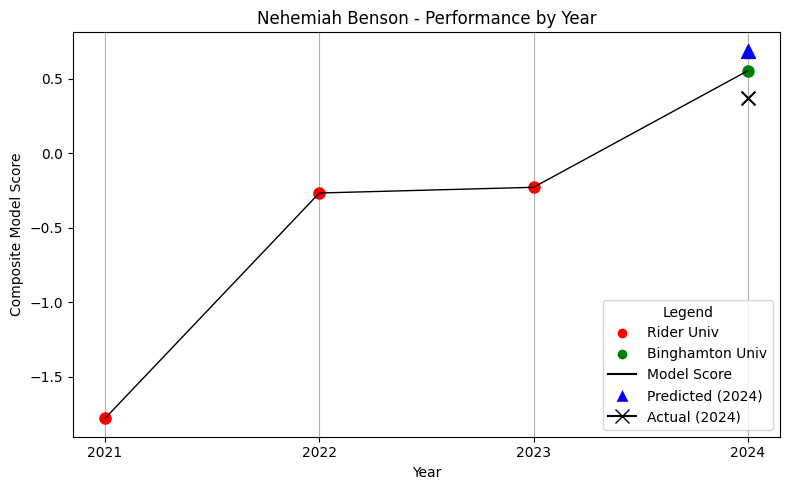

In [ ]:
from matplotlib.lines import Line2D

def plot_player_trajectory(player_name, df_with_score, combined_df):
    player_df = df_with_score[df_with_score['player'] == player_name].sort_values(by='year')
    summary = combined_df[combined_df['player'] == player_name]

    # Team color map
    team_colors = {'Rider': 'red', 'Binghamton': 'green'}
    marker_style = 'o'

    plt.figure(figsize=(8, 5))

    # Plot each point with team-specific color
    for _, row in player_df.iterrows():
        team_color = team_colors.get(row['team'], 'gray')
        plt.plot(row['year'], row['model_score'], marker=marker_style, markersize=8, color=team_color, linestyle='-')

    # Connect points with neutral line
    plt.plot(player_df['year'], player_df['model_score'], color='black', linewidth=1, label='Model Score')

    # Predicted and actual 2024 markers
    if not summary.empty:
        y4_pred = summary['Predicted'].values[0]
        y4_actual = summary['Actual Composite Score (2024)'].values[0]
        plt.scatter(2024, y4_pred, color='blue', marker='^', s=100, label='Predicted (2024)', zorder=5)
        plt.scatter(2024, y4_actual, color='black', marker='x', s=100, label='Actual (2024)', zorder=5)

    # Custom legend entries for teams
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Rider Univ', markerfacecolor='red', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Binghamton Univ', markerfacecolor='green', markersize=8),
        Line2D([0], [0], color='black', label='Model Score'),
        Line2D([0], [0], marker='^', color='w', label='Predicted (2024)', markerfacecolor='blue', markersize=10),
        Line2D([0], [0], marker='x', color='black', label='Actual (2024)', markersize=10)
    ]

    # Final touches
    plt.title(f'{player_name} - Performance by Year')
    plt.xlabel('Year')
    plt.ylabel('Composite Model Score')
    plt.xticks(player_df['year'])
    plt.grid(axis='x')
    plt.legend(handles=legend_elements, title='Legend', loc='lower right')
    plt.tight_layout()
    plt.show()

plot_player_trajectory('Nehemiah Benson', benson_df, combined_df)
